In [1]:
%load_ext autoreload
%autoreload 2

# Comparison of binding sequences for documented and predicted sRNA-mRNA interactions

## Imports

In [2]:
import os
import pandas as pd
import re

from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.srv.io.manage.script_manager import script_preamble

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jax
import subprocess



# Load data

### Database

In [3]:
fn_RNAInter = os.path.join('..', 'data', 'sRNA', 'RNAInter', 'Download_data_RR.csv')
fn_merged = os.path.join('..', 'data', 'sRNA', 'merged_EcoCyc_RNAInter.csv')
data = pd.read_csv(fn_RNAInter)
merged = pd.read_csv(fn_merged)
try:
    data = data.drop(columns=['Unnamed: 0'])
    merged = merged.drop(columns=['Unnamed: 0'])
except:
    pass


In [4]:
merged[merged['Name'] == 'chiX']['Sequence'].iloc[1]

'ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCCTCTTTGACGGGCCAATAGCGATATTGGCCATTTTTTT'

### Predicted interactions

In [5]:
fn = './data/05_orthogonality_mRNA_official/2023_11_21_095238/inter_data_raw.json'

sim_data_l = load_json_as_dict(fn)

k1 = list(sim_data_l.keys())[0]
k2 = list(sim_data_l[k1].keys())[0]
header = list(sim_data_l[k1][k2].keys())
default_vals = {
    'id1': '', 'id2': '', 'E': 0.0, 'E_norm': 0.0, 'bpList': '', 'hybridDPfull': ''
}
for s, v in sim_data_l.items():
    if len(v.values()) < len(sim_data_l[k1]):
        diffs = set(sim_data_l[k1].keys()) - set(v.keys())
        for d in diffs:
            sim_data_l[s][d] = default_vals
        
header

['id1', 'id2', 'E', 'E_norm', 'bpList', 'hybridDPfull']

# Get interaction subsequences 

In [5]:
merged

,Name,ID,Category,Symbol,Sequence,Database
0,acnA,NCBI:946724,mRNA,acnA,ATTCGGAACGAGGCCTGAAGCAGTGTCGCCGTCCCTCTGCCTTGCA...,RNAInter
1,acrZ,NCBI:945365,mRNA,acrZ,ACTTACTACTGTCTTCGGGGGGTCCGAGGTTTCTGGGGGGTCGTAC...,RNAInter
2,arcZ,NCBI:2847690,sRNA,arcZ,CTCATGTTGACCGCTTGTTTAGCAGCTTCAAGGAAGCTGAAGGGCA...,RNAInter
3,argR,NCBI:947861,mRNA,argR,GACAATGGCGATAGTATGGCGGTTGTTTCTTTCCCATCTCTACTCA...,RNAInter
4,arrS,NCBI:11115378,sRNA,arrS,CTCTCCCTCTCTTTCTCTCTTCTCCGCGGCGATACGATCCGAGATG...,RNAInter
...,...,...,...,...,...,...
596,msrA,"chromosome:NC_000913.3, Gene ID:948734",mRNA,msrA,ATGAGTTTATTTGATAAAAAGCATCTGGTTTCCCCCGCCGATGCCC...,sRNATarBase
597,hdeA,"chromosome:NC_000913.3, Gene ID:948025",mRNA,hdeA,ATGAAAAAAGTATTAGGCGTTATTCTTGGTGGTCTGCTTCTTCTGC...,sRNATarBase
598,hdeB,"chromosome:NC_000913.3, Gene ID:948026",mRNA,hdeB,ATGAATATTTCATCTCTCCGTAAAGCGTTTATTTTTATGGGCGCTG...,sRNATarBase
599,fliC,"chromosome:NC_002695.1, Gene ID:",mRNA,fliC,ATGGCACAAGTCATTAATACCAACAGCCTCTCGCTGATCACTCAAA...,sRNATarBase


In [6]:
def process_bplist(bplist, idx):
    return [int(i.replace(')', ',').split(',')[idx]) for i in bplist.split('(')[1:]]


def longest_common_substring(x, y):
    """ Bard """
    import difflib
    # Create a sequence matcher object
    matcher = difflib.SequenceMatcher(None, x, y)

    # Find the longest common substring match
    match = matcher.find_longest_match()

    # Extract the longest common substring
    if match.size != 0:
        substring = x[match.a:match.a + match.size]
        return substring
    else:
        return ""
    

def create_groups(x, y):
    """ CGPT """
    groups = []
    group = []
    for i, num in enumerate(x):
        if i in y:
            if group:
                groups.append(group)
                group = []
            group.append(num)
        else:
            group.append(num)
    groups.append(group)
    return groups

In [7]:
for k1 in sim_data_l:
    for k2, v in sim_data_l[k1].items():
        if v['id1'] == '' or v['id2'] == '':
            sim_data_l[k1][k2]['subsequence_groups'] = []
            continue
        seq1, cat1 = merged[(merged['Name'] == v['id1']) | (merged['Symbol'] == v['id1'])][['Sequence', 'Category']].iloc[0].to_list()
        seq2, cat2 = merged[(merged['Name'] == v['id2']) | (merged['Symbol'] == v['id2'])][['Sequence', 'Category']].iloc[0].to_list()
        
        if (cat1 == 'mRNA') and (cat2 == 'mRNA'):
            print(k1, k2)
            break
        
        subsequence, i = (seq1, 0) if cat1 == 'mRNA' else (seq2, 1)
        idxs = np.array(sorted(process_bplist(v['bpList'], i)))
        breakup = np.where(idxs[1:] - idxs[:-1] > 1)[0] + 1
        subsequence_groups = []
        for g in create_groups(idxs, breakup):
            subsequence_groups.append(''.join(np.array(list(subsequence))[np.array(g) - 1]))
        
        sim_data_l[k1][k2]['subsequence_groups'] = subsequence_groups
        

In [8]:
sim_data_l['arcZ']['acnA']['subsequence_groups']

['CTCA', 'C', 'CACCT', 'GTGGG', 'CCAGCACACT', 'TCGGAGGCCA', 'GC']

# Run bpRNA on all sequences

Takes ca. 10 minutes on 37 sRNA x 232 mRNA

In [9]:
config = {
    "experiment": {
        "purpose": "tests",
        "no_visualisations": False,
        "no_numerical": False,
        "debug_mode": False
    }
}
data_writer = None
config, data_writer = script_preamble(config, data_writer)

In [10]:
def write_dbn(outname, outdir, id_name, seq, db):
    fn = os.path.join(outdir, outname + '.dbn')
    with open(fn, 'w') as f:
        f.writelines('>' + id_name + '\n' +
                     seq + '\n' +
                     db + '\n')
    return fn


# def make_db(bplist, seq_len):
#     db = np.array(list('.' * seq_len))
#     db[process_bplist(bplist, idx=0)] = '('
#     db[process_bplist(bplist, idx=1)] = ')'
#     return ''.join(db)


def execute_perl_script(*args):
    """ Bard """
    script_path = './bpRNA.pl'
    try:
        subprocess.run(["perl", script_path, *args])
    except Exception as e:
        print(f"Error executing Perl script: {e}")


for k1 in sim_data_l:
    data_writer.subdivide_writing('st')
    data_writer.subdivide_writing(k1, safe_dir_change=False)
    data_writer.unsubdivide()
    data_writer.subdivide_writing('dbn')
    data_writer.subdivide_writing(k1, safe_dir_change=False)
    
    for k2 in sim_data_l[k1]:
        bplist = sim_data_l[k1][k2]['bpList']
        # make_db(bplist, seq_len=len(db))
        db = sim_data_l[k1][k2]['hybridDPfull'].replace('&', '')
        seq = merged[merged['Symbol'] == k1]['Sequence'].iloc[0] + \
            merged[merged['Symbol'] == k2]['Sequence'].iloc[0]
        fn = write_dbn(k1 + '_' + k2, data_writer.write_dir, id_name='arcZ', seq=seq, db=db)
        try:
            execute_perl_script(fn, fn.replace('.dbn', '').replace('dbn', 'st'))
        except:
            print(k1, k2)

arrS ilvI


# Examine bpRNA

In [6]:
BPRNA_STRUCTURE_TYPES = ["S", "H", "B", "I", "M", "X", "E", "PK", "PKBP", "NCBP", "segment"]

def process_st(fn_st):
    
    # Match all digits in the string and replace them with an empty string
    pattern1 = r'[0-9]'
    pattern2 = "[^0-9]"
    
    with open(fn_st, 'r') as f:
        reads = [l.split(' ')[:2] for l in f.readlines()[7:]]
        motifs = [l[0] for l in reads]
        motifs = list(map(lambda x: [re.sub(pattern1, '', x.replace('.', '')), [int(re.sub(pattern2, '', xx)) for xx in x.split('.')]], motifs))
        
        motif_lengths = [l[1].split('..') for l in reads]
        motif_lengths = list(map(lambda x: int(x[1]) - int(x[0]) if len(x) > 1 else 1, motif_lengths))
        
    d = {}
    for (a, b), ml in zip(motifs, motif_lengths):
        d.setdefault(a, {}).setdefault('motif_groups', []).append(b)
        d.setdefault(a, {}).setdefault('motif_length', []).append(ml)
        
    return d
    
    
def aggregate_motifs(sim_data):
    structures = pd.DataFrame()
    dir_st = './data/08_comparison_sequences/2023_11_22_225107/st'
    for id1 in sim_data:
        for id2 in sim_data[id1]:
            fn_st = os.path.join(dir_st, id1, id1 + '_' + id2 + '.st')
            if not os.path.isfile(fn_st):
                continue
            structures_d = {}
            d = process_st(fn_st)
            structures_d[('sRNA', '')] = id1
            structures_d[('Target', '')] = id2
            for s in BPRNA_STRUCTURE_TYPES:
                if d.get(s):
                    structures_d[('Mean Length', s)] = np.mean(d[s]['motif_length'])
                    structures_d[('Num in seq', s)] = len(d[s]['motif_groups'])
                else:
                    structures_d[('Mean Length', s)] = [0]
                    structures_d[('Num in seq', s)] = [0]
            structures = pd.concat([structures, pd.DataFrame.from_dict(structures_d)])
            
    structures = structures.reset_index().drop(columns='index')
    return structures[structures.columns[:2].to_list() + sorted(structures.columns[2:])]
    
    

In [7]:
fn_st = './data/08_comparison_sequences/2023_11_22_225107/st/arcZ/arcZ_acnA.st'

d = process_st(fn_st)


In [12]:
# motifs = aggregate_motifs({'arcZ': sim_data_l['arcZ'], 'arrS': sim_data_l['arrS']})
motifs = aggregate_motifs(sim_data=sim_data_l)
# motifs.to_csv('motifs_mean_length.csv')
motifs

/tmp/ipykernel_569466/3331885936.py:46: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  structures = structures.reset_index().drop(columns='index')


sRNA Target Mean Length                                           ...  \
                            B      E       H         I  M NCBP PK PKBP  ...   
0     arcZ   chiP    1.000000   10.0   371.0  0.000000  0  1.0  0    0  ...   
1     arcZ   acrZ    2.000000   16.0   336.0  0.000000  0  1.0  0    0  ...   
2     arcZ    asr    1.000000  102.0   311.0  0.000000  0  1.0  0    0  ...   
3     arcZ   cheZ    0.000000  194.5   116.0  3.333333  0  1.0  0    0  ...   
4     arcZ   acnA    0.333333   35.5   481.0  1.600000  0  1.0  0    0  ...   
...    ...    ...         ...    ...     ...       ... ..  ... ..  ...  ...   
8563  symR   yphD    1.333333  420.5   587.0  0.125000  0  1.0  0    0  ...   
8564  symR   yhjJ    1.000000  269.5  1451.0  0.000000  0  1.0  0    0  ...   
8565  symR   uhpT    0.500000  632.5   587.0  1.000000  0  1.0  0    0  ...   
8566  symR   tolC    0.000000  560.5   795.0  1.900000  0  1.0  0    0  ...   
8567  symR   yccE    0.000000  288.5  1080.0  2.500000  0  1.0  0    0  ...   

     Num in seq                                       
              E  H   I  M NCBP PK PKBP  S  X segment  
0             1  1   0  0    9  0    0  2  0       1  
1             2  1   2  0   22  0    0  4  0       1  
2             2  1   0  0   17  0    0  3  0       1  
3             2  1   6  0   19  0    0  4  0       1  
4             2  1  10  0   34  0    0  9  0       1  
...         ... ..  .. ..  ... ..  ... .. ..     ...  
8563          2  1   8  0   31  0    0  8  0       1  
8564          2  1   0  0   12  0    0  2  0       1  
8565          2  1   4  0   19  0    0  5  0       1  
8566          2  1  10  0   22  0    0  6  0       1  
8567          2  1  12  0   35  0    0  8  0       1  

[8568 rows x 24 columns]

Text(0.5, 1.0, 'Mean length of motif')

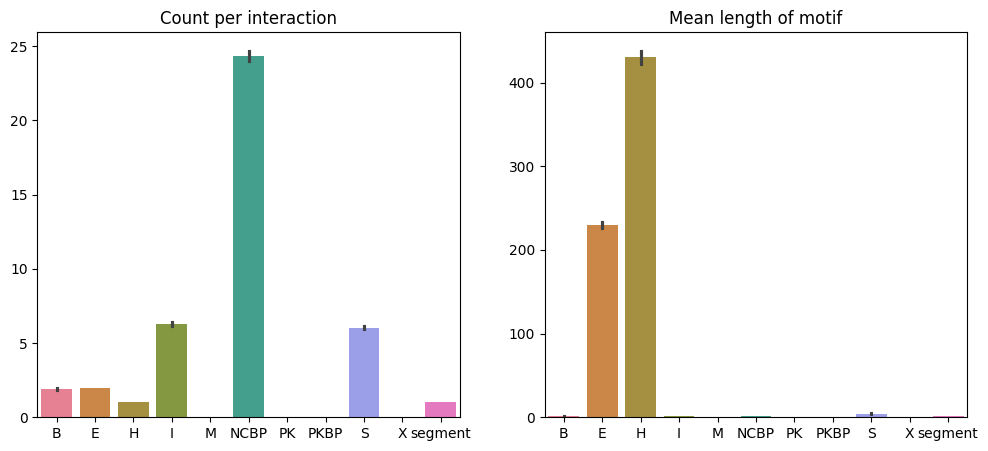

In [24]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(1,2,1)
sns.barplot(motifs['Num in seq'])
plt.title('Count per interaction')
ax = plt.subplot(1,2,2)
sns.barplot(motifs['Mean Length'])
plt.title('Mean length of motif')

Text(0.5, 0.98, 'Relative counts and mean length per interaction')

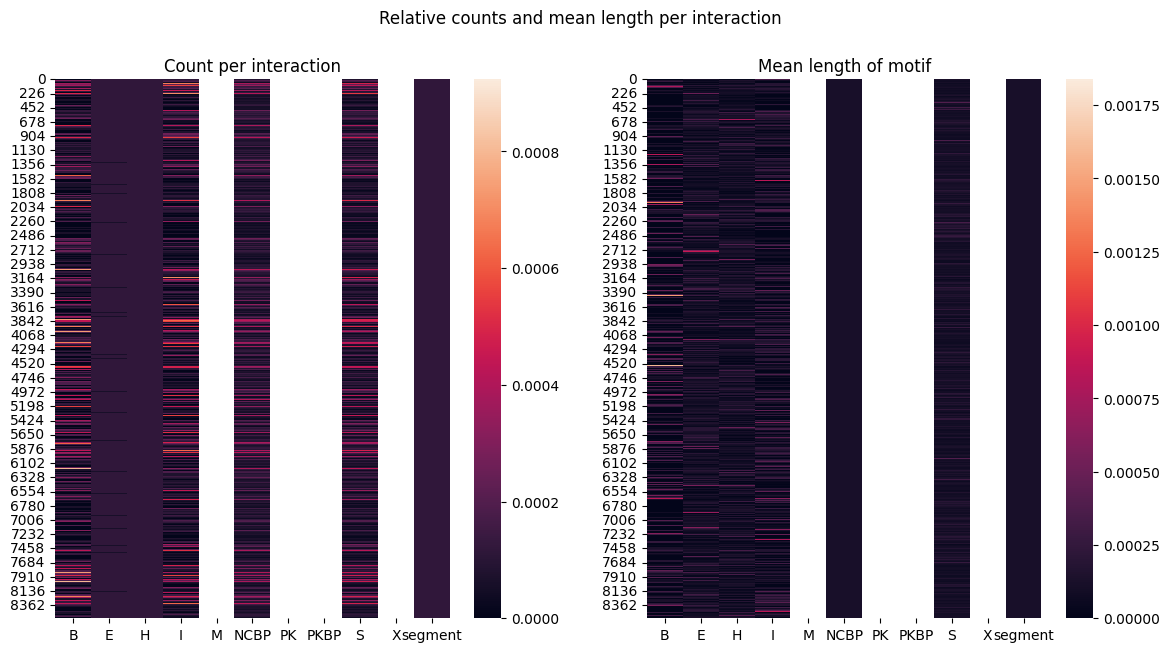

In [26]:
plt.figure(figsize=(14, 7))
ax = plt.subplot(1,2,1)
sns.heatmap(motifs['Num in seq'] / motifs['Num in seq'].sum(axis=0))
plt.title('Count per interaction')
ax = plt.subplot(1,2,2)
sns.heatmap(motifs['Mean Length'] / motifs['Mean Length'].sum(axis=0))
plt.title('Mean length of motif')

plt.suptitle('Relative counts and mean length per interaction')